In [91]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from scipy.stats import linregress
from scipy.signal import argrelextrema


data = pd.read_csv("15M_EURUSD.csv")
# data['Datetime'] = pd.to_datetime(data['Datetime'])
# data.set_index('Datetime', inplace=True)


order = 2
max_idx = argrelextrema(data['High'].values, np.greater, order=order)[0]
min_idx = argrelextrema(data['Low'].values, np.less, order=order)[0]


# labels = np.ones(len(data))
labels = np.zeros(len(data))  
labels[max_idx] = 1 
labels[min_idx] = 2

data['Signal'] = labels
data.drop(columns="Volume",inplace=True)


df = pd.DataFrame(data)


In [92]:
df['ATR'] = df.ta.atr(length=14)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA20'] = df.ta.sma(length=20)
df['MA50'] = df.ta.sma(length=50)
df['MA100'] = df.ta.sma(length=100)

In [93]:
df = df.fillna(0)

In [94]:
df = df.dropna()

attributes=['High','Low','Open','Close','ATR', 'RSI', 'Average', 'MA20', 'MA50', 'MA100'] #, 'slopeMA20', 'slopeMA50', 'slopeMA100', 'AverageSlope', 'RSISlope']
X = df[attributes]
y = df["Signal"]

df 

,Datetime,Open,High,Low,Close,Adj Close,Signal,ATR,RSI,Average,MA20,MA50,MA100
0,2024-08-08 00:00:00,1.093016,1.093255,1.093016,1.093135,1.093135,0.0,0.000000,0.000000,1.093135,0.000000,0.000000,0.000000
1,2024-08-08 00:15:00,1.093255,1.093374,1.093135,1.093374,1.093374,0.0,0.000000,0.000000,1.093255,0.000000,0.000000,0.000000
2,2024-08-08 00:30:00,1.093374,1.093733,1.093374,1.093733,1.093733,1.0,0.000000,0.000000,1.093553,0.000000,0.000000,0.000000
3,2024-08-08 00:45:00,1.093613,1.093613,1.093135,1.093135,1.093135,0.0,0.000000,0.000000,1.093374,0.000000,0.000000,0.000000
4,2024-08-08 01:00:00,1.093016,1.093255,1.093016,1.093135,1.093135,2.0,0.000000,0.000000,1.093135,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3973,2024-10-04 21:15:00,1.097936,1.098056,1.097936,1.097936,1.097936,0.0,0.000462,51.455219,1.097996,1.096997,1.099271,1.101366
3974,2024-10-04 21:30:00,1.097936,1.097936,1.097574,1.097574,1.097574,0.0,0.000455,46.776174,1.097755,1.097063,1.099160,1.101309
3975,2024-10-04 21:45:00,1.097695,1.098056,1.097574,1.098056,1.098056,0.0,0.000457,52.923113,1.097815,1.097153,1.099066,1.101258
3976,2024-10-04 22:00:00,1.097333,1.097333,1.097213,1.097213,1.097213,0.0,0.000484,43.465215,1.097273,1.097213,1.098949,1.101199


In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons,make_classification
from sklearn.ensemble import RandomForestClassifier


model = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=-1)
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


model.fit(X_train, y_train)


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# model.fit(X_train_scaled, y_train)
# y_pred = model.predict(X_test_scaled)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
# print(y_pred)

In [103]:

signal =  [*y_pred_train,*y_pred]


df["KNNsignal"] = signal

# # df["signal"].describe()
df["KNNsignal"].value_counts()
# # len(signal)
# df

# y_pred.value_counts

# for tree in model.estimators_:
#     print(tree.predict(X_test))


KNNsignal
0.0    3394
2.0     304
1.0     280
Name: count, dtype: int64

In [104]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)


Cross-validation scores: [0.72056515 0.74254317 0.72327044 0.71540881 0.72798742]


In [105]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

# print(df['signal'].value_counts()*100/df['signal'])

pred_test = np.random.choice([0,1,2],len(y_pred))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 100.00%
Accuracy test: 75.25%
Accuracy Gambler: 34.30%


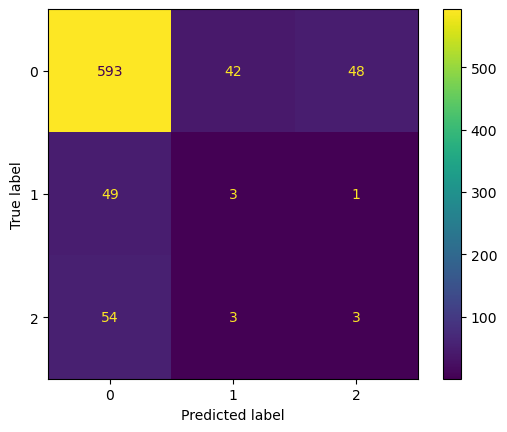

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)  # specify labels for classes
dis = ConfusionMatrixDisplay(cm)
dis.plot()  # Optional: specify color map  cmap=plt.cm.Blues
plt.show()

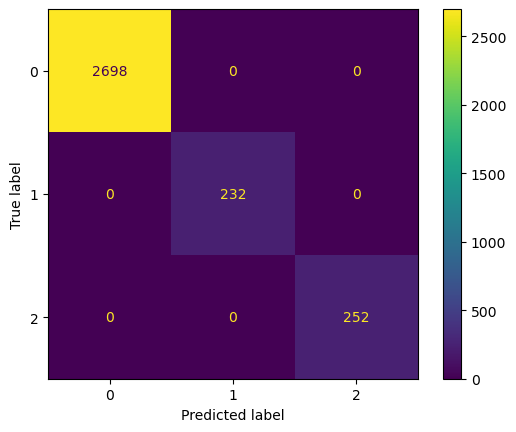

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train ,y_pred_train)  # specify labels for classes
dis = ConfusionMatrixDisplay(cm)
dis.plot()  # Optional: specify color map  cmap=plt.cm.Blues
plt.show()

In [108]:
from backtesting import Strategy, Backtest
import numpy as np
import pandas as pd

class SmaCross(Strategy):
    size = 10  # Size of each trade
    sl_coef = 0.01  # Coefficient for stop loss

    def init(self):
        pass

    def next(self):
        price = self.data["Close"][-1]

        long_sl = price * 0.997
        long_tp = price * 1.03
        short_sl = price * 1.007
        short_tp = price * 0.97

        signal = self.data['KNNsignal'][-1]

        if signal == 2:  # Buy signal
            self.position.close()
            self.buy(sl=long_sl, tp=long_tp,size=self.size)
        elif signal ==1:  # Sell signal
            self.position.close()
            self.sell(sl=short_sl, tp=short_tp,size=self.size)
        

        # if signal == 2: 
        #     self.position.close()
        #     self.buy(size=self.size)
        # if signal == 1: 
        #     self.position.close()
        #     self.sell(size=self.size)

        # for trade in self.trades: 
        #             if trade.is_long: 
        #                 trade.sl = max(trade.sl or -np.inf, 
        #                             self.data["Close"][-1] * 0.98) 
        #             else: # short
        #                 trade.sl = min(trade.sl or np.inf, 
        #                             self.data["Close"][-1] * 1.02) 

       

bt = Backtest(df, SmaCross, cash=100000, commission=.001)
stats = bt.run()

print(stats)
bt.plot()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12612\668734980.py:47: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, SmaCross, cash=100000, commission=.001)


Start                                     0.0
End                                    3977.0
Duration                               3977.0
Exposure Time [%]                   99.069884
Equity Final [$]                 99993.394428
Equity Peak [$]                      100000.0
Return [%]                          -0.006606
Buy & Hold Return [%]                0.373047
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.006606
Avg. Drawdown [%]                   -0.006606
Max. Drawdown Duration                 3976.0
Avg. Drawdown Duration                 3976.0
# Trades                                583.0
Win Rate [%]                          6.51801
Best Trade [%]                       0.343552
Worst Trade [%]                     -0.655104
Avg. Trade [%]                    

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2532', ...)

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


order = 15
max_idx = argrelextrema(data['Close'].values, np.greater, order=order)[0]
min_idx = argrelextrema(data['Close'].values, np.less, order=order)[0]
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['Close'],
  label='Maxima', s=50, color=colors[1], marker='v')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Close'],
  label='Minima', s=50, color=colors[2], marker='^')

plt.legend()
plt.show()